In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
# from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.metrics import silhouette_score


### Script Structure:

* read in metadata file (sample_genus_and_species.csv)
* read in ska distances.distances.tsv
* data clean: 
    * make join key indeces consistent
    * assert no missing data
    * remove waters
    * data reorganization:
        * create pivot table (with SNP_distance values) with multi-index including:
            * genus
            * species
            * corrected_species
            * sample_prefix
* OA:
    * heatmap with maca data (shows snp distance of zero)
    * clustermap with non truncated sketches and some reference genomes
    * silhouette scores for ska (need sourmash raw data)
    
* visualizations/ exploration
    * clustermap with non-truncated sketches (for different k sizes [3, 9, 12, 15, 24])
    * hierarchical clustering
    * do comparison graph to overlay most similar species for each comparison
        * organize color palette for similar species to show up in the same familiy of colors

* Data Output:
    * output entries that were potentially mislabeled
        * show clusters that are heterogeneous and output samples that were in the minority 
    
    
    
* create database, or grab other reference genomes for comparisons
        
        
        
* show pileups of different genes to show missing overlaps between different species
* how does this change with differences between the genomes (introducing snps)
     * show how sourmash discards huge regions based on snp difference 
     * do line up with sourmash vs. snps
     * resolution lost with dendogram for sourmash (problems with the big differences early on making hte dnedogram come together later)
     * plots for original, annd dendrogram
     * show plot with reference and expect people talk about diffs between fastq fasta. 
     * why we chose to look at ska
     * method ska
     * plots ska with dendogram
     * sourmash hashing (random sampling)
     * list the name 

<hr>

## Data Retrieval/Cleaning/Formatting

In [13]:
# with location metadata:

new_metadata = pd.read_csv(
    "/Users/phoenix.logan/code/skeeters/data/CMS001_CMS002_MergedAnnotations.csv", 
    header = 0, 
#     index_col = "czbiohub-mosquito_sequences_id",
)

species_id = new_metadata[[
    "czbiohub-mosquito_sequences_id",
    "visual_genus", 
    "visual_species", 
    "compute_genus", 
    "compute_species"
]]

species_id.rename(
    columns = {
        'visual_genus': 'genus',
        'visual_species': 'species',
        'compute_species': 'sourmash_species',
        'compute_genus': 'sourmash_genus',
        'czbiohub-mosquito_sequences_id': ''
    }, 
    inplace = True
)
species_id.set_index("", inplace=True)

len(species_id) # 161
species_id.head()

/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,genus,species,sourmash_genus,sourmash_species
,,,,
CMS_001_RNA_A_S1,Culex,erythrothorax,Culex,erythrothorax
CMS_002_RNA_A_S1,Culex,tarsalis,Culex,tarsalis
CMS_003_RNA_A_S2,Culiseta,particeps,Culiseta,particeps
CMS_004_RNA_A_S2,Culex,pipiens,Culex,pipiens
CMS_005_RNA_A_S3,Culiseta,incidens,Culiseta,incidens


In [14]:
species_id_skeeters = pd.read_csv(
    "~/code/skeeters/data/sample_genus_and_species.csv", 
    header=0, 
    index_col=0
)
species_id_skeeters.columns = species_id_skeeters.columns.str.replace(" ", "_")

species_id_skeeters.rename(
    columns = {

        'corrected_species': 'sourmash_species',
        'corrected_genus': 'sourmash_genus'
    }, 
    inplace = True
)
species_id_skeeters.head()

,genus,species,sourmash_genus,sourmash_species
CMS_001_RNA_A_S1,Culex,erythrothorax,Culex,erythrothorax
CMS_002_10a_Rb_S119_L004,Culex,quinquefasciatus,Culex,quinquefasciatus
CMS_002_13a_Rb_S120_L004,Culex,quinquefasciatus,Culex,quinquefasciatus
CMS_002_16a_Rb_S121_L004,Aedes,aegypti,Aedes,aegypti
CMS_002_17a_Rb_S122_L004,Aedes,aegypti,Aedes,aegypti


In [15]:
#Troubleshooting

combined = pd.merge(
        species_id, 
        species_id_skeeters, #
        left_index=True, 
        right_index=True, 
        suffixes=('_190325', '_old')
    )


# remove data with no species label (water samples)
water_samples = combined[
        (combined.species_190325.isnull()) 
        & 
        (combined.sourmash_species_190325.isnull())
    ].index.to_list()
    
filtered_out_water = combined[~combined.index.isin(water_samples)]

filtered_out_water.query(
    "species_190325 != species_old | " + 
    "genus_190325 != genus_old | " +
    "sourmash_species_190325 != sourmash_species_old | " + 
    "sourmash_genus_190325 != sourmash_genus_old"
)

,genus_190325,species_190325,sourmash_genus_190325,sourmash_species_190325,genus_old,species_old,sourmash_genus_old,sourmash_species_old
CMS_058_RNA_A_S9,NaN,NaN,Culex,erythrothorax,NaN,NaN,Culex,erythrothorax


In [16]:

def clean_data(distances_tsv, tailing, metadata=species_id):
    '''
    clean data and remove water samples
    '''
    
    # read in data tables with sample distances computed with ska (split kmer analysis)
    dd_tsv = pd.read_csv(distances_tsv, sep='\t')
    dd_tsv.columns = dd_tsv.columns.str.replace(" ", "_")
    shape_dd_tsv = dd_tsv.shape
    
    # Add prefix columns and size
    dd_tsv["Sample_1"] = dd_tsv.apply(lambda row: row["Sample_1"].split(tailing)[0], axis=1)
    dd_tsv["Sample_2"] = dd_tsv.apply(lambda row: row["Sample_2"].split(tailing)[0], axis=1)

    # re-organize columns
    dd_tsv = dd_tsv[["Sample_1", 
                     "Sample_2", 
                     "Matches", 
                     "Mismatches", 
                     "Jaccard_Index",
                     "Mash-like_distance",
                     "SNPs",
                     "SNP_distance",
                    ]]
    
    water_samples = metadata[
        (metadata.species.isnull()) 
        & 
        (metadata.sourmash_species.isnull())
    ].index.to_list()
    
    # remove data with no species label (water samples)
    filtered_out_water = dd_tsv[~(
        (dd_tsv.Sample_1.isin(water_samples)) 
        | 
        (dd_tsv.Sample_2.isin(water_samples))
    )]

    return filtered_out_water


def create_pivot(df, values="SNP_distance", diagonal=0):    
    ''' create pivot tables with sample 1 and sample 2 correlations'''
    
    dd_tsv_pivot = df.pivot(
        columns="Sample_1", 
        index="Sample_2", 
        values=values
    )
    dd_tsv_pivot = dd_tsv_pivot.loc[dd_tsv_pivot.columns, :]
    np.fill_diagonal(dd_tsv_pivot.values, diagonal)
    dd_tsv_pivot = dd_tsv_pivot.fillna(0) + dd_tsv_pivot.T.fillna(0) - np.diag(dd_tsv_pivot.values.diagonal())
    return dd_tsv_pivot


def add_metadata_to_pivot(df, metadata_fields, metadata=species_id):
    """join metadata onto pivot table for axis labeling"""
    
    dd_tsv_pivot_w_labels = pd.merge(
        df.reset_index(), 
        metadata[metadata_fields], #
        how='left',
        left_on="Sample_1", 
        right_index=True, 
    ).reset_index().set_index(
    ["Sample_1"] + metadata_fields
    ).drop(["index"], axis=1)
    
    return dd_tsv_pivot_w_labels


def get_linkage(pivot_df):
    '''clustering linkage'''
    
    cdist = scipy.spatial.distance.squareform(pivot_df)
    return scipy.cluster.hierarchy.linkage(cdist, method="ward")


def get_cluster_map(pivot_df, linkage, num_clusters, extra=True):
    """cluster distance matrix and re-assign species as cluster species mode"""
    
    clusters = fcluster(linkage, num_clusters, criterion='maxclust')
    
    cluster_map = pd.DataFrame()
    
    if extra:
        cluster_map['genus']   = pivot_df.index.get_level_values(1)
        cluster_map['species'] = pivot_df.index.get_level_values(2)
        cluster_map['sourmash_genus'] = pivot_df.index.get_level_values(3)
        cluster_map['sourmash_species'] = pivot_df.index.get_level_values(4)
        
    cluster_map["Sample_1"] = pivot_df.columns
    cluster_map['cluster'] = clusters
    cluster_map.set_index("Sample_1", inplace=True)

    cluster_chunks = []
    for clust in cluster_map.cluster.unique():
        subset = cluster_map[cluster_map.cluster == clust]
        species_mode = subset.species.mode()[0]
        genus_mode = subset[subset["species"] == species_mode].genus.values[0]
        subset["ska_species"] = species_mode
        subset["ska_genus"] = genus_mode
        cluster_chunks.append(subset)

    cluster_map_w_ska = pd.concat(cluster_chunks)
#     cluster_map_w_ska = cluster_map_w_ska[[
#         "genus", 
#         "species", 
#         "sourmash_genus",
#         "sourmash_species", 
#         "ska_genus",
#         "ska_species"
#     ]]
    return cluster_map_w_ska

    
def correlation_matrix(pivot_w_labels, linkage, cluster_map, figsize = (60,60)):
    '''correlatian matrix comparing visual, sourmash, and ska species assignment'''
    
    original_species_coloring = dict(
        zip(
            pivot_w_labels.index.get_level_values(2).unique(), 
            sns.color_palette("bright", 12)
        )
    )
    
    sourmash_species_coloring = dict(
        zip(
            pivot_w_labels.index.get_level_values(4).unique(), 
            sns.color_palette("deep", 12)
        )
    )
    
    ska_species_coloring = dict(
        zip(
            pivot_w_labels.index.get_level_values(6).unique(), 
            sns.color_palette("dark", 13)
        )
    )   
    
    pivot_index = pivot_w_labels.index
    
    key_colors_original = pivot_index.get_level_values(2).map(original_species_coloring)
    key_colors_sourmash = pivot_index.get_level_values(4).map(sourmash_species_coloring)
    key_colors_ska = pivot_index.get_level_values(6).map(ska_species_coloring)
    
    key_colors_labels = [
        key_colors_original, 
        key_colors_sourmash, 
        key_colors_ska
    ]

    return sns.clustermap(
            pivot_w_labels.reset_index().drop([
                "genus", 
                "species", 
                "sourmash_genus",
                "sourmash_species",
                "ska_genus",
                "ska_species"
            ], axis=1).set_index("Sample_1"),
            metric="correlation", 
            row_colors=key_colors_labels, 
            col_colors=key_colors_labels,
            figsize = figsize,
            col_linkage = linkage,
            row_linkage = linkage,
            cbar_kws = {'label': 'distance'},
            xticklabels= pivot_w_labels.index.get_level_values(4),
            yticklabels= pivot_w_labels.index.get_level_values(6)
    )


def join_on_ska_labels(fp, metadata, tailing, k, values="SNP_distance"):
    '''read in fp and create pivot distance matrix with old and new species labels'''
    
    df_cleaned = clean_data(
    fp, 
    metadata=metadata,
    tailing=tailing
    )

    dd_pivot = create_pivot(
        df_cleaned, 
        values=values, 
        diagonal=0
    )

    metadata_fields = [
        "genus", 
        "species", 
        "sourmash_genus",
        "sourmash_species"
    ]

    dd_pivot_w_labels = add_metadata_to_pivot(
        dd_pivot, 
        metadata_fields, 
        metadata=metadata
    )

    linkage = get_linkage(dd_pivot)

    cluster_map = get_cluster_map(
        dd_pivot_w_labels, 
        linkage, 
        k, 
        extra=True
    )

    ska_metadata_fields = metadata_fields + ["ska_genus", "ska_species"]

    final_pivot_w_labels = add_metadata_to_pivot(
        dd_pivot, 
        ska_metadata_fields, 
        metadata=cluster_map
    )
    
    return final_pivot_w_labels, cluster_map, linkage


def wrap_clustermap_and_mismatches(fp, metadata, tailing, k=10, figsize = (60,60), values="SNP_distance", diagonal=0):
    '''create clustermap with new and old species assigned labels'''
    
    dd_pivot_w_ska_labels, cluster_map, linkage = join_on_ska_labels(
        fp, 
        metadata, 
        tailing,
        k,
        values=values
    )
    
    correlation_matrix(
        dd_pivot_w_ska_labels, 
        linkage, 
        cluster_map, 
        figsize = (60,60)
    )
    
    #return dd_pivot_w_ska_labels
    return dd_pivot_w_ska_labels.query(
        'species != sourmash_species | ' + 
        'species != ska_species | ' + 
        'sourmash_species != ska_species'
    )


def hierarchical_clustering(fp, metadata, tailing, k, values="SNP_distance"):

    dd_pivot_w_ska_labels, *_ = join_on_ska_labels(
        fp, 
        metadata, 
        tailing, 
        k,
        values="SNP_distance"
    )
    
    cdist = scipy.spatial.distance.squareform(dd_pivot_w_ska_labels)
    Z = shc.linkage(cdist, method="ward")
    fig = plt.figure(figsize=(25, 10))

    dn = shc.dendrogram(
        Z, 
        leaf_font_size=8, 
        labels=dd_pivot_w_ska_labels.index.get_level_values(6), 
        color_threshold=0.008
    )
    
    return dn


def get_silhouette_score(fp, metadata, tailing, values="SNP_distance", correlation=False):
    '''use silhouette metric to see how compact and distinct clusters are '''
    
    clean_df = clean_data(
    fp, 
    metadata=metadata,
    tailing=tailing
    )

    pivot_df = create_pivot(
        clean_df, 
        values=values, 
        diagonal=0
    )
    
    cdist = scipy.spatial.distance.squareform(pivot_df)  
    linkage = scipy.cluster.hierarchy.linkage(cdist, method="ward")
    clusters = fcluster(linkage, 10, criterion='maxclust')
    
    cluster_map = pd.DataFrame()
    
    cluster_map["Sample_1"] = pivot_df.columns
    cluster_map['cluster'] = clusters
    cluster_map.set_index("Sample_1", inplace=True)
    
    return silhouette_score(pivot_df, metric="precomputed", labels=cluster_map["cluster"])


<hr>

## Exploration

/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

,,,,,,,CMS_001_RNA_A_S1,CMS_002_10a_Rb_S119_L004,CMS_002_13a_Rb_S120_L004,CMS_002_16a_Rb_S121_L004,CMS_002_17a_Rb_S122_L004,CMS_002_17b_Rb_S123_L004,CMS_002_17c_Rb_S124_L004,CMS_002_17d_Rb_S125_L004,CMS_002_17e_Rb_S126_L004,CMS_002_18a_Rb_S128_L004,...,CMS_050_RNA_A_S23,CMS_051_RNA_A_S8,CMS_052_RNA_A_S7,CMS_053_RNA_A_S8,CMS_054_RNA_A_S11,CMS_055_RNA_A_S9,CMS_056_RNA_A_S10,CMS_057_RNA_A_S11,CMS_058_RNA_A_S9,CMS_059_RNA_A_S10
Sample_1,genus,species,sourmash_genus,sourmash_species,ska_genus,ska_species,,,,,,,,,,,,,,,,,,,,,
CMS_002_7a_Rb_S118_L004,Culex,quinquefasciatus,Culex,quinquefasciatus,Culiseta,incidens,0.009372,0.011909,0.012172,0.011753,0.010757,0.010500,0.011137,0.010639,0.009653,0.010243,...,0.009851,0.009970,0.007801,0.008248,0.007212,0.008091,0.007667,0.007646,0.009367,0.010034
CMS_014_RNA_A_S5,Culiseta,incidens,Culiseta,incidens,Culiseta,particeps,0.008592,0.011413,0.011630,0.011188,0.010536,0.010331,0.010938,0.010250,0.009680,0.009846,...,0.008859,0.009106,0.007551,0.007949,0.007237,0.007708,0.007691,0.007459,0.008498,0.009215
CMS_025_RNA_A_S7,Culex,tarsalis,Culiseta,particeps,Culiseta,particeps,0.007866,0.009800,0.009721,0.009604,0.009309,0.009124,0.009548,0.009196,0.008801,0.009145,...,0.008245,0.008428,0.007367,0.007687,0.007035,0.007368,0.007368,0.007073,0.007954,0.008743
CMS_026_RNA_A_S18,Culex,tarsalis,Culiseta,incidens,Culiseta,incidens,0.008304,0.010450,0.010507,0.010038,0.009652,0.009455,0.010019,0.009473,0.009165,0.009374,...,0.008554,0.008842,0.007698,0.007857,0.007010,0.007485,0.007340,0.007469,0.008158,0.009029
CMS_040_RNA_A_S21,Culex,tarsalis,Culex,tarsalis,Culex,pipiens,0.004259,0.004415,0.004674,0.007428,0.007440,0.007399,0.007447,0.007238,0.007342,0.007905,...,0.004149,0.003906,0.003688,0.004091,0.002089,0.003662,0.004040,0.004023,0.004432,0.003579
CMS_045_RNA_A_S2,Culex,tarsalis,Culex,erythrothorax,Culex,erythrothorax,0.000401,0.004853,0.005138,0.008420,0.008280,0.008133,0.008205,0.008001,0.008130,0.008758,...,0.000426,0.005309,0.000424,0.000361,0.002872,0.000327,0.000431,0.000443,0.000608,0.004460
CMS_058_RNA_A_S9,NaN,NaN,Culex,erythrothorax,Culex,erythrothorax,0.000868,0.007962,0.008662,0.009700,0.009525,0.009419,0.009581,0.009076,0.009182,0.009937,...,0.000681,0.007729,0.000591,0.000580,0.002799,0.000553,0.000506,0.000739,0.000000,0.006415


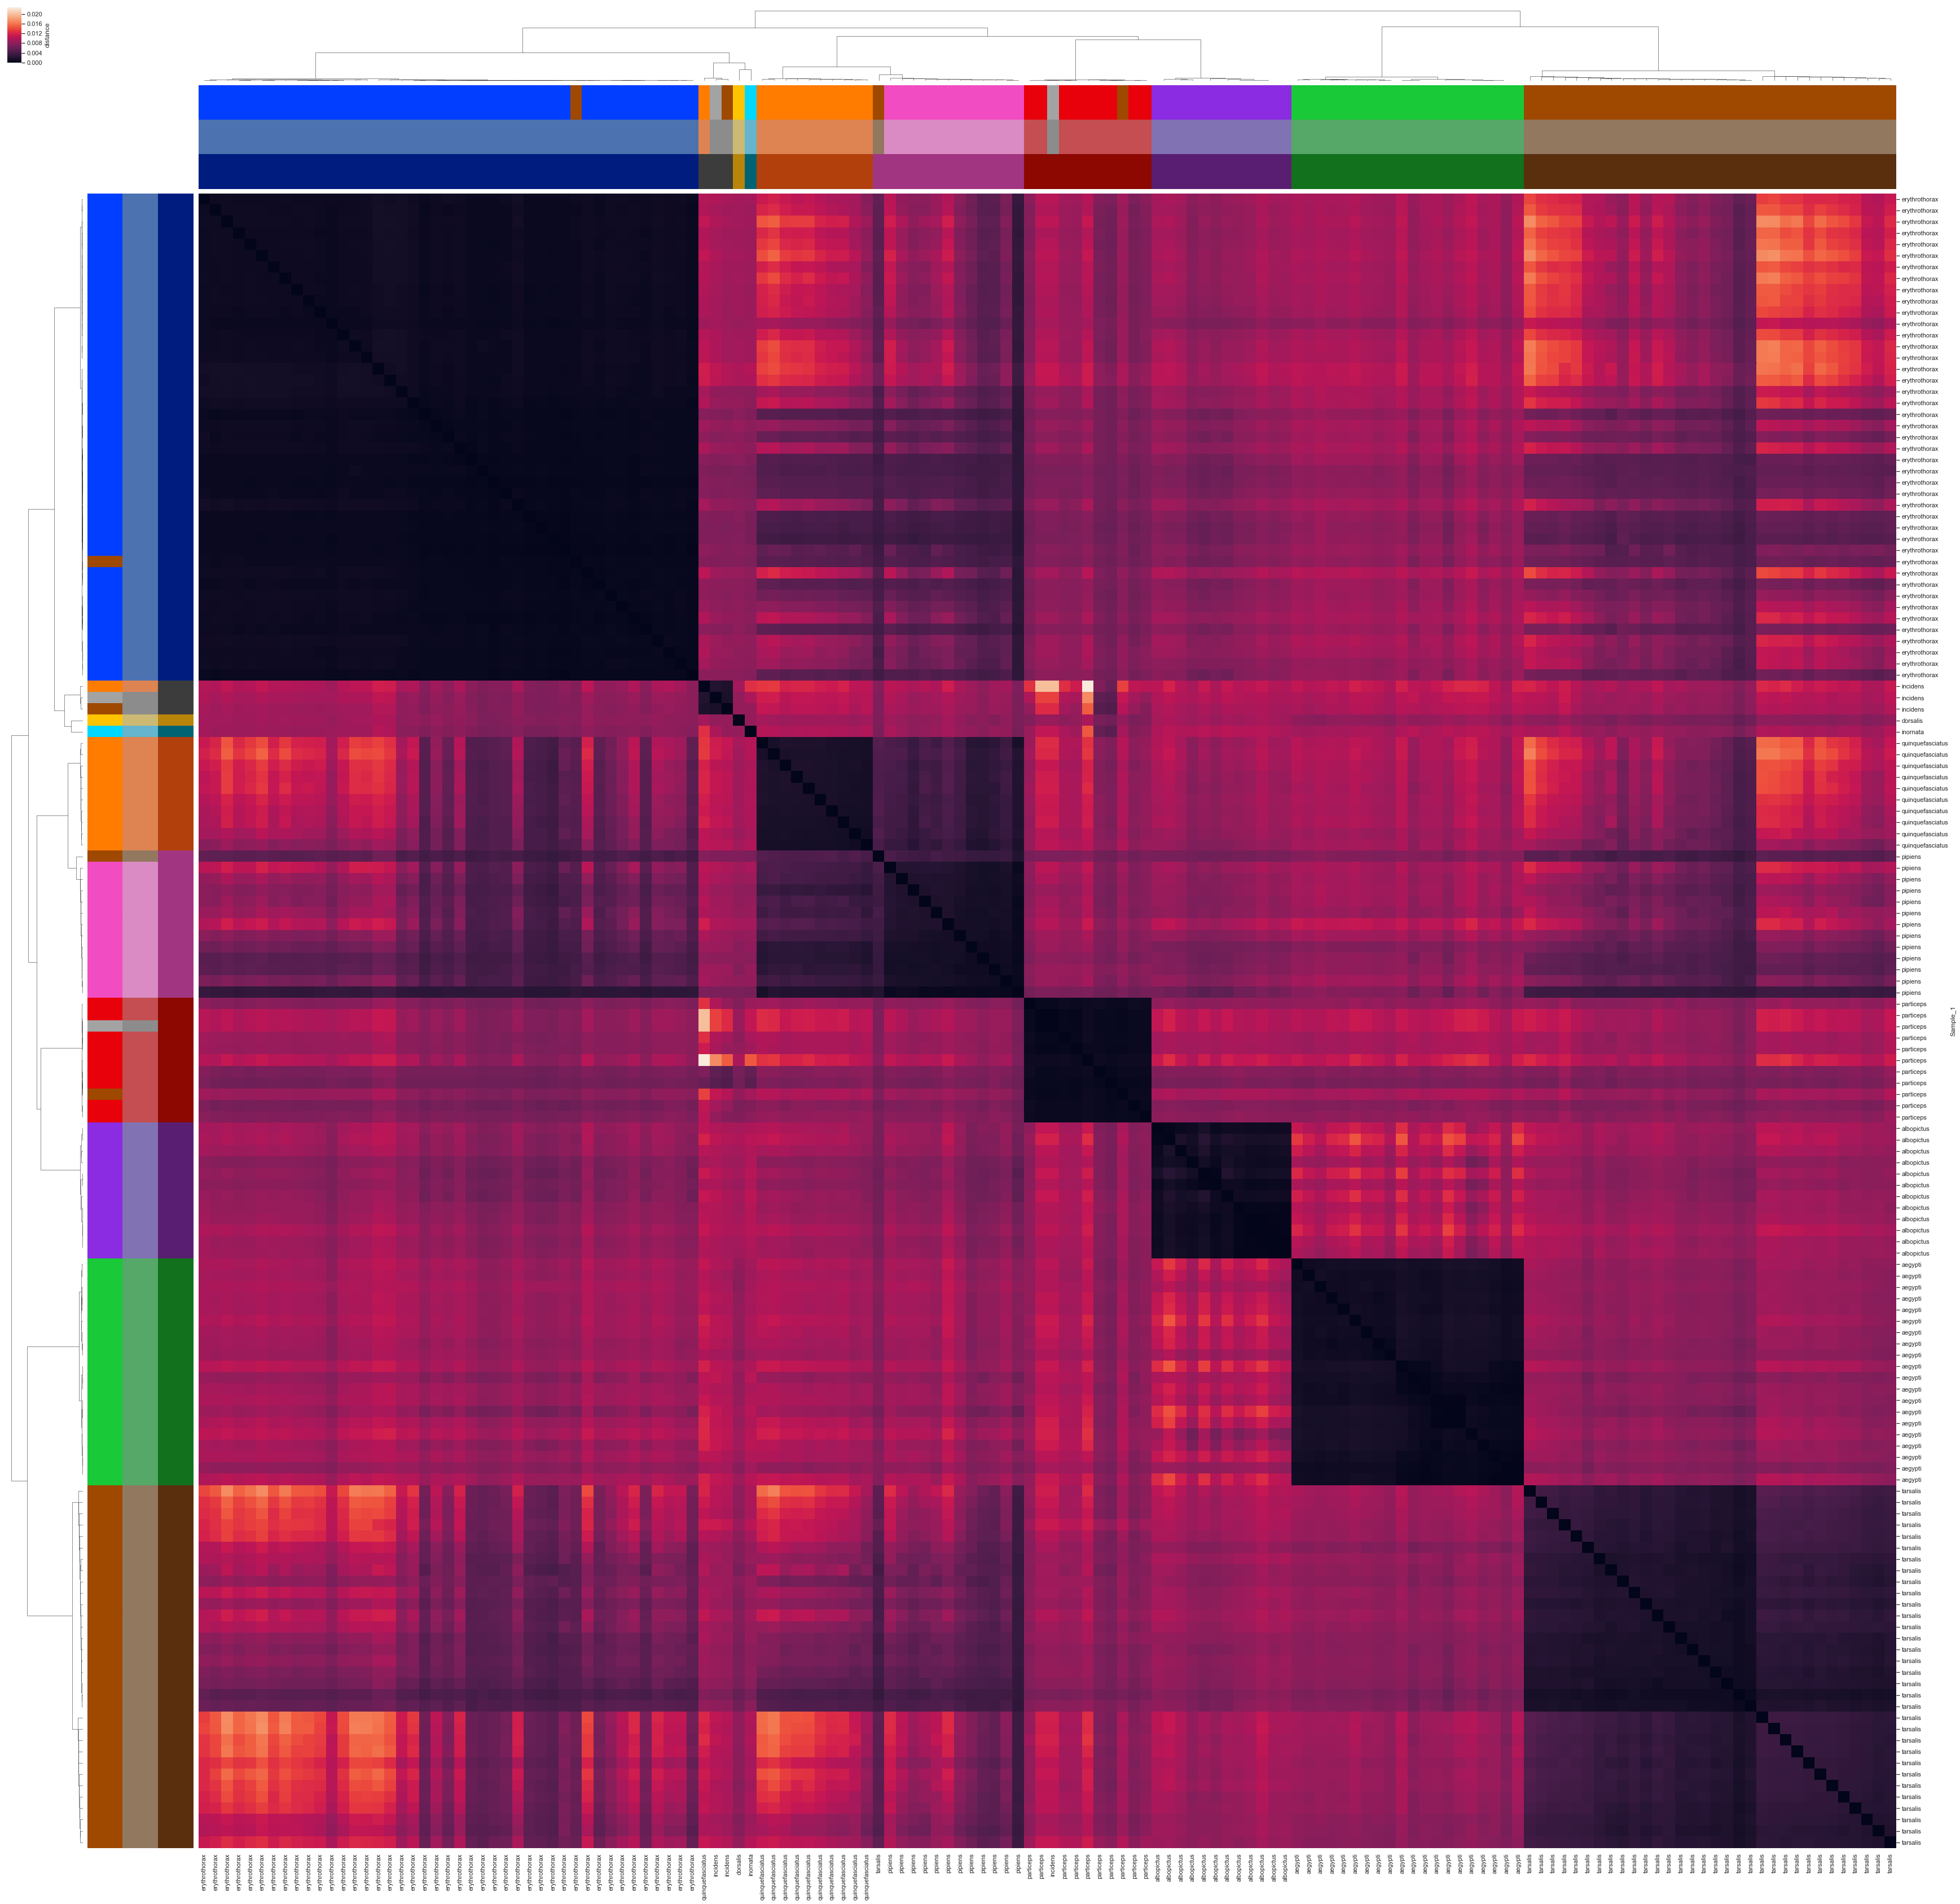

In [17]:
wrap_clustermap_and_mismatches(
    's3://phoenixlogan-data/mosquito/nf-kmer-similarity/08-06-2019/no-truncation/ksize_15.distances.tsv',  
    species_id, 
    "_ksize_15", 
    k=10, 
    figsize = (60,60), 
    values="SNP_distance", 
    diagonal=0
)


In [18]:
final_pivot_w_labels, cluster_map, linkage = join_on_ska_labels(
    's3://phoenixlogan-data/mosquito/nf-kmer-similarity/08-06-2019/no-truncation/ksize_15.distances.tsv',
    species_id,
    "_ksize_15",
    10
)



/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [19]:
cluster_map.query(
    'genus != sourmash_genus | ' +
    'genus != ska_genus | ' +
    'sourmash_genus != ska_genus | ' +
    'species != sourmash_species | ' + 
    'species != ska_species | ' + 
    'sourmash_species != ska_species'
)

,genus,species,sourmash_genus,sourmash_species,cluster,ska_species,ska_genus
Sample_1,,,,,,,
CMS_045_RNA_A_S2,Culex,tarsalis,Culex,erythrothorax,1,erythrothorax,Culex
CMS_058_RNA_A_S9,NaN,NaN,Culex,erythrothorax,1,erythrothorax,Culex
CMS_014_RNA_A_S5,Culiseta,incidens,Culiseta,incidens,7,particeps,Culiseta
CMS_025_RNA_A_S7,Culex,tarsalis,Culiseta,particeps,7,particeps,Culiseta
CMS_040_RNA_A_S21,Culex,tarsalis,Culex,tarsalis,6,pipiens,Culex
CMS_002_7a_Rb_S118_L004,Culex,quinquefasciatus,Culex,quinquefasciatus,2,incidens,Culiseta
CMS_026_RNA_A_S18,Culex,tarsalis,Culiseta,incidens,2,incidens,Culiseta


In [20]:
# len(cluster_map[cluster_map["species"] == "erythrothorax"].index.to_list())

# cluster_map[['genus', 'species', '']].to_csv("")
new_metadata.columns

Index(['NewIDseqName', 'OldIDseqName', 'czbiohub-mosquito_sequences_id',
       'host', 'sample_type', 'nucleotide_type', 'collection_date',
       'collection_lat', 'collection_long', 'Habitat', 'Population',
       'collected_by', 'preservation_method', 'sex', 'life_stage',
       'visual_genus', 'visual_species', 'compute_genus', 'compute_species',
       'blood_fed', 'sample_unit', 'known_organism', 'detection_method',
       'library_prep', 'sequencer', 'rna_dna_input_ng', 'library_prep_batch',
       'extraction_batch', 'Notes:', 'Genus_test', 'Species_test', 'read1',
       'read2'],
      dtype='object')

In [21]:
len(new_metadata)

161

In [22]:
joined = pd.merge(
    new_metadata,
    cluster_map[[
        'sourmash_genus',
        'sourmash_species',
        'ska_genus',
        'ska_species'
    ]],
    left_on='czbiohub-mosquito_sequences_id',
    right_index=True
)

In [23]:
len(joined)

146

In [76]:
joined[[
    "visual_genus",
    "visual_species",
    "sourmash_genus",
    "sourmash_species",
    "ska_genus",
    "ska_species"
]].query(
    'visual_genus != sourmash_genus | ' +
    'visual_genus != ska_genus | ' +
    'sourmash_genus != ska_genus | ' +
    'visual_species != sourmash_species | ' + 
    'visual_species != ska_species | ' + 
    'sourmash_species != ska_species'
)

,visual_genus,visual_species,sourmash_genus,sourmash_species,ska_genus,ska_species
13,Culiseta,incidens,Culiseta,incidens,Culiseta,particeps
24,Culex,tarsalis,Culiseta,particeps,Culiseta,particeps
25,Culex,tarsalis,Culiseta,incidens,Culiseta,incidens
39,Culex,tarsalis,Culex,tarsalis,Culex,pipiens
44,Culex,tarsalis,Culex,erythrothorax,Culex,erythrothorax
57,NaN,NaN,Culex,erythrothorax,Culex,erythrothorax
67,Culex,quinquefasciatus,Culex,quinquefasciatus,Culiseta,incidens


In [79]:
joined[['NewIDseqName', 'OldIDseqName', 'czbiohub-mosquito_sequences_id',
       'host', 'sample_type', 'nucleotide_type', 'collection_date',
       'collection_lat', 'collection_long', 'Habitat', 'Population',
       'collected_by', 'preservation_method', 'sex', 'life_stage',
       'visual_genus', 'visual_species', 'sourmash_genus', 'sourmash_species', 'ska_genus', 'ska_species',
       'blood_fed', 'sample_unit', 'known_organism', 'detection_method',
       'library_prep', 'sequencer', 'rna_dna_input_ng', 'library_prep_batch',
       'extraction_batch', 'Notes:', 'Genus_test', 'Species_test', 'read1',
       'read2']].to_csv("/Users/phoenix.logan/code/skeeters/data/CMS001_CMS002_MergedAnnotations.csv", index=False)

In [29]:
# Silhouette scores comparing clustering with mash-like distance and snp distance

silhouette_snp = get_silhouette_score(
    's3://phoenixlogan-data/mosquito/nf-kmer-similarity/08-06-2019/no-truncation/ksize_15.distances.tsv', 
    species_id_skeeters, 
    "_ksize_15", 
    values="SNP_distance"
)

silhouette_mash = get_silhouette_score(
    's3://phoenixlogan-data/mosquito/nf-kmer-similarity/08-06-2019/no-truncation/ksize_15.distances.tsv', 
    species_id_skeeters, 
    "_ksize_15", 
    values="Mash-like_distance"
)

print(
    "silhouettes: ",
    f"SNP Distance {silhouette_snp}", 
    f"Mash Distance: {silhouette_mash}"
)


/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



silhouettes:  SNP Distance 0.7616773304900353 Mash Distance: 0.31543006436575377


/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



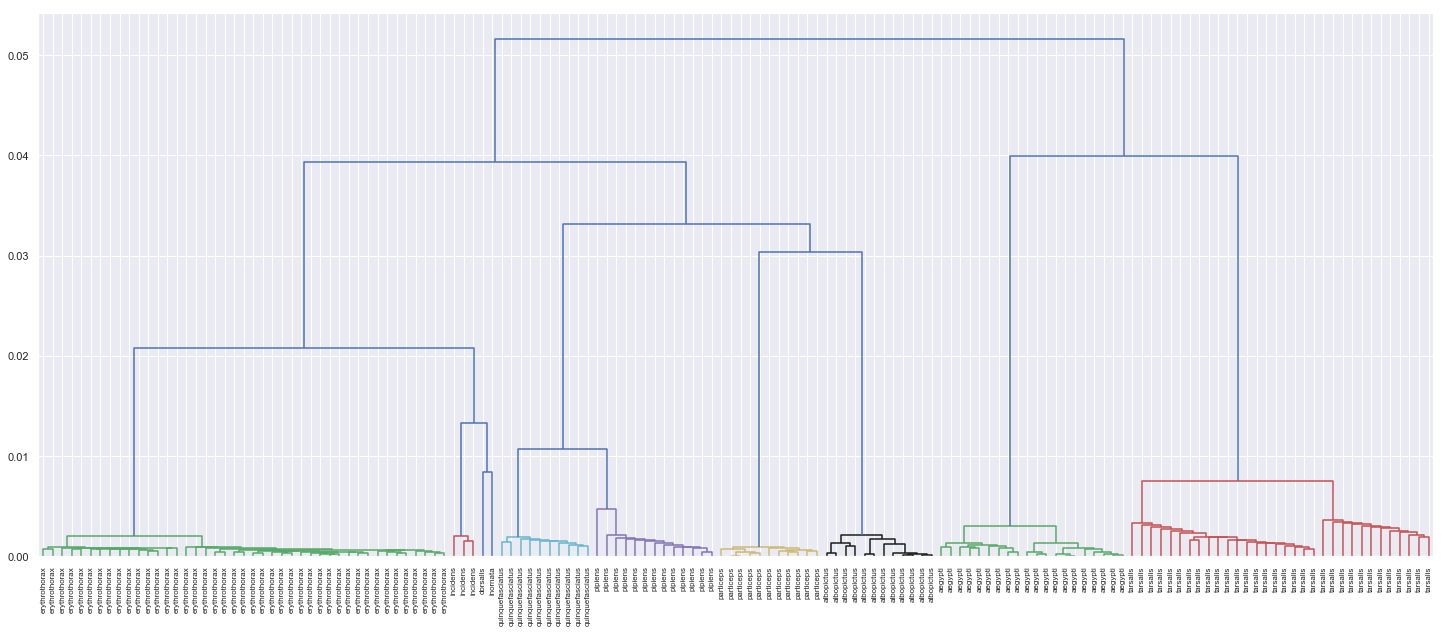

In [30]:
dn = hierarchical_clustering(
    's3://phoenixlogan-data/mosquito/nf-kmer-similarity/08-06-2019/no-truncation/ksize_15.distances.tsv', 
    species_id_skeeters, 
    "_ksize_15", 
    10,
    values="SNP_distance"
)

/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

,,,,,,,CMS_0015_RNA_A_S13,CMS_001_16_S5_L001,CMS_001_17_S6_L001,CMS_001_32_S7_L001,CMS_001_RNA_A_S1,CMS_002_10a_Rb_S119_L004,CMS_002_13a_Rb_S120_L004,CMS_002_16a_Rb_S121_L004,CMS_002_17a_Rb_S122_L004,CMS_002_17b_Rb_S123_L004,...,CMS_051_RNA_A_S8,CMS_052_RNA_A_S7,CMS_053_RNA_A_S8,CMS_054_RNA_A_S11,CMS_055_RNA_A_S9,CMS_056_RNA_A_S10,CMS_057_RNA_A_S11,CMS_058_RNA_A_S9,CMS_059_RNA_A_S10,CMS_060_RNA_A_S12
Sample_1,genus,species,sourmash_genus,sourmash_species,ska_genus,ska_species,,,,,,,,,,,,,,,,,,,,,
CMS_001_16_S5_L001,NaN,NaN,NaN,NaN,Culex,erythrothorax,0.000646,0.000000,0.000891,0.008132,0.000923,0.007647,0.008273,0.010329,0.009394,0.009380,...,0.007206,0.000835,0.000726,0.002003,0.000614,0.000826,0.000914,0.000956,0.006634,0.009592
CMS_001_17_S6_L001,NaN,NaN,NaN,NaN,Culex,erythrothorax,0.000459,0.000891,0.000000,0.008087,0.000825,0.007558,0.008167,0.010533,0.009226,0.009555,...,0.007304,0.000721,0.000603,0.001653,0.000597,0.000609,0.000840,0.000900,0.007014,0.009839
CMS_001_32_S7_L001,NaN,NaN,NaN,NaN,Culex,tarsalis,0.005394,0.008132,0.008087,0.000000,0.006042,0.005466,0.005503,0.008399,0.007879,0.008333,...,0.001055,0.005745,0.006479,0.001828,0.003906,0.006247,0.005174,0.006586,0.005078,0.009384
CMS_002_53a_Rb_S7_L004,Culex,pipiens,Culex,pipiens,Culex,erythrothorax,0.000417,0.000929,0.000917,0.007387,0.000777,0.006823,0.007191,0.008352,0.008196,0.008021,...,0.006575,0.000845,0.000524,0.001606,0.000234,0.001424,0.000881,0.000851,0.005820,0.008349
CMS_002_7a_Rb_S118_L004,Culex,quinquefasciatus,Culex,quinquefasciatus,Culex,incidens,0.007555,0.010337,0.010824,0.009732,0.008346,0.010469,0.010402,0.010927,0.009756,0.009911,...,0.009446,0.007994,0.008564,0.005535,0.007791,0.007531,0.007545,0.008933,0.009388,0.006575
CMS_025_RNA_A_S7,Culex,tarsalis,Culiseta,particeps,Culiseta,particeps,0.007250,0.008720,0.009043,0.009012,0.007122,0.010278,0.009841,0.009151,0.008541,0.008752,...,0.007985,0.007051,0.007504,0.005701,0.006747,0.007204,0.006879,0.007575,0.008125,0.004565
CMS_026_RNA_A_S18,Culex,tarsalis,Culiseta,incidens,Culex,incidens,0.007250,0.008716,0.009576,0.009102,0.007405,0.010202,0.010205,0.009474,0.008835,0.008919,...,0.008289,0.007374,0.007532,0.005737,0.006720,0.006733,0.007058,0.007654,0.008326,0.003864
CMS_040_RNA_A_S21,Culex,tarsalis,Culex,tarsalis,Culex,pipiens,0.002305,0.005963,0.006273,0.004387,0.002728,0.003804,0.004078,0.007780,0.007313,0.007439,...,0.002327,0.002866,0.003169,0.000806,0.001995,0.003038,0.002863,0.002832,0.002122,0.007156
CMS_045_RNA_A_S2,Culex,tarsalis,Culex,erythrothorax,Culex,erythrothorax,0.000316,0.000969,0.000685,0.005913,0.000383,0.005002,0.005049,0.008642,0.007823,0.007746,...,0.004008,0.000523,0.000323,0.001264,0.000358,0.000512,0.000539,0.000644,0.003519,0.006588


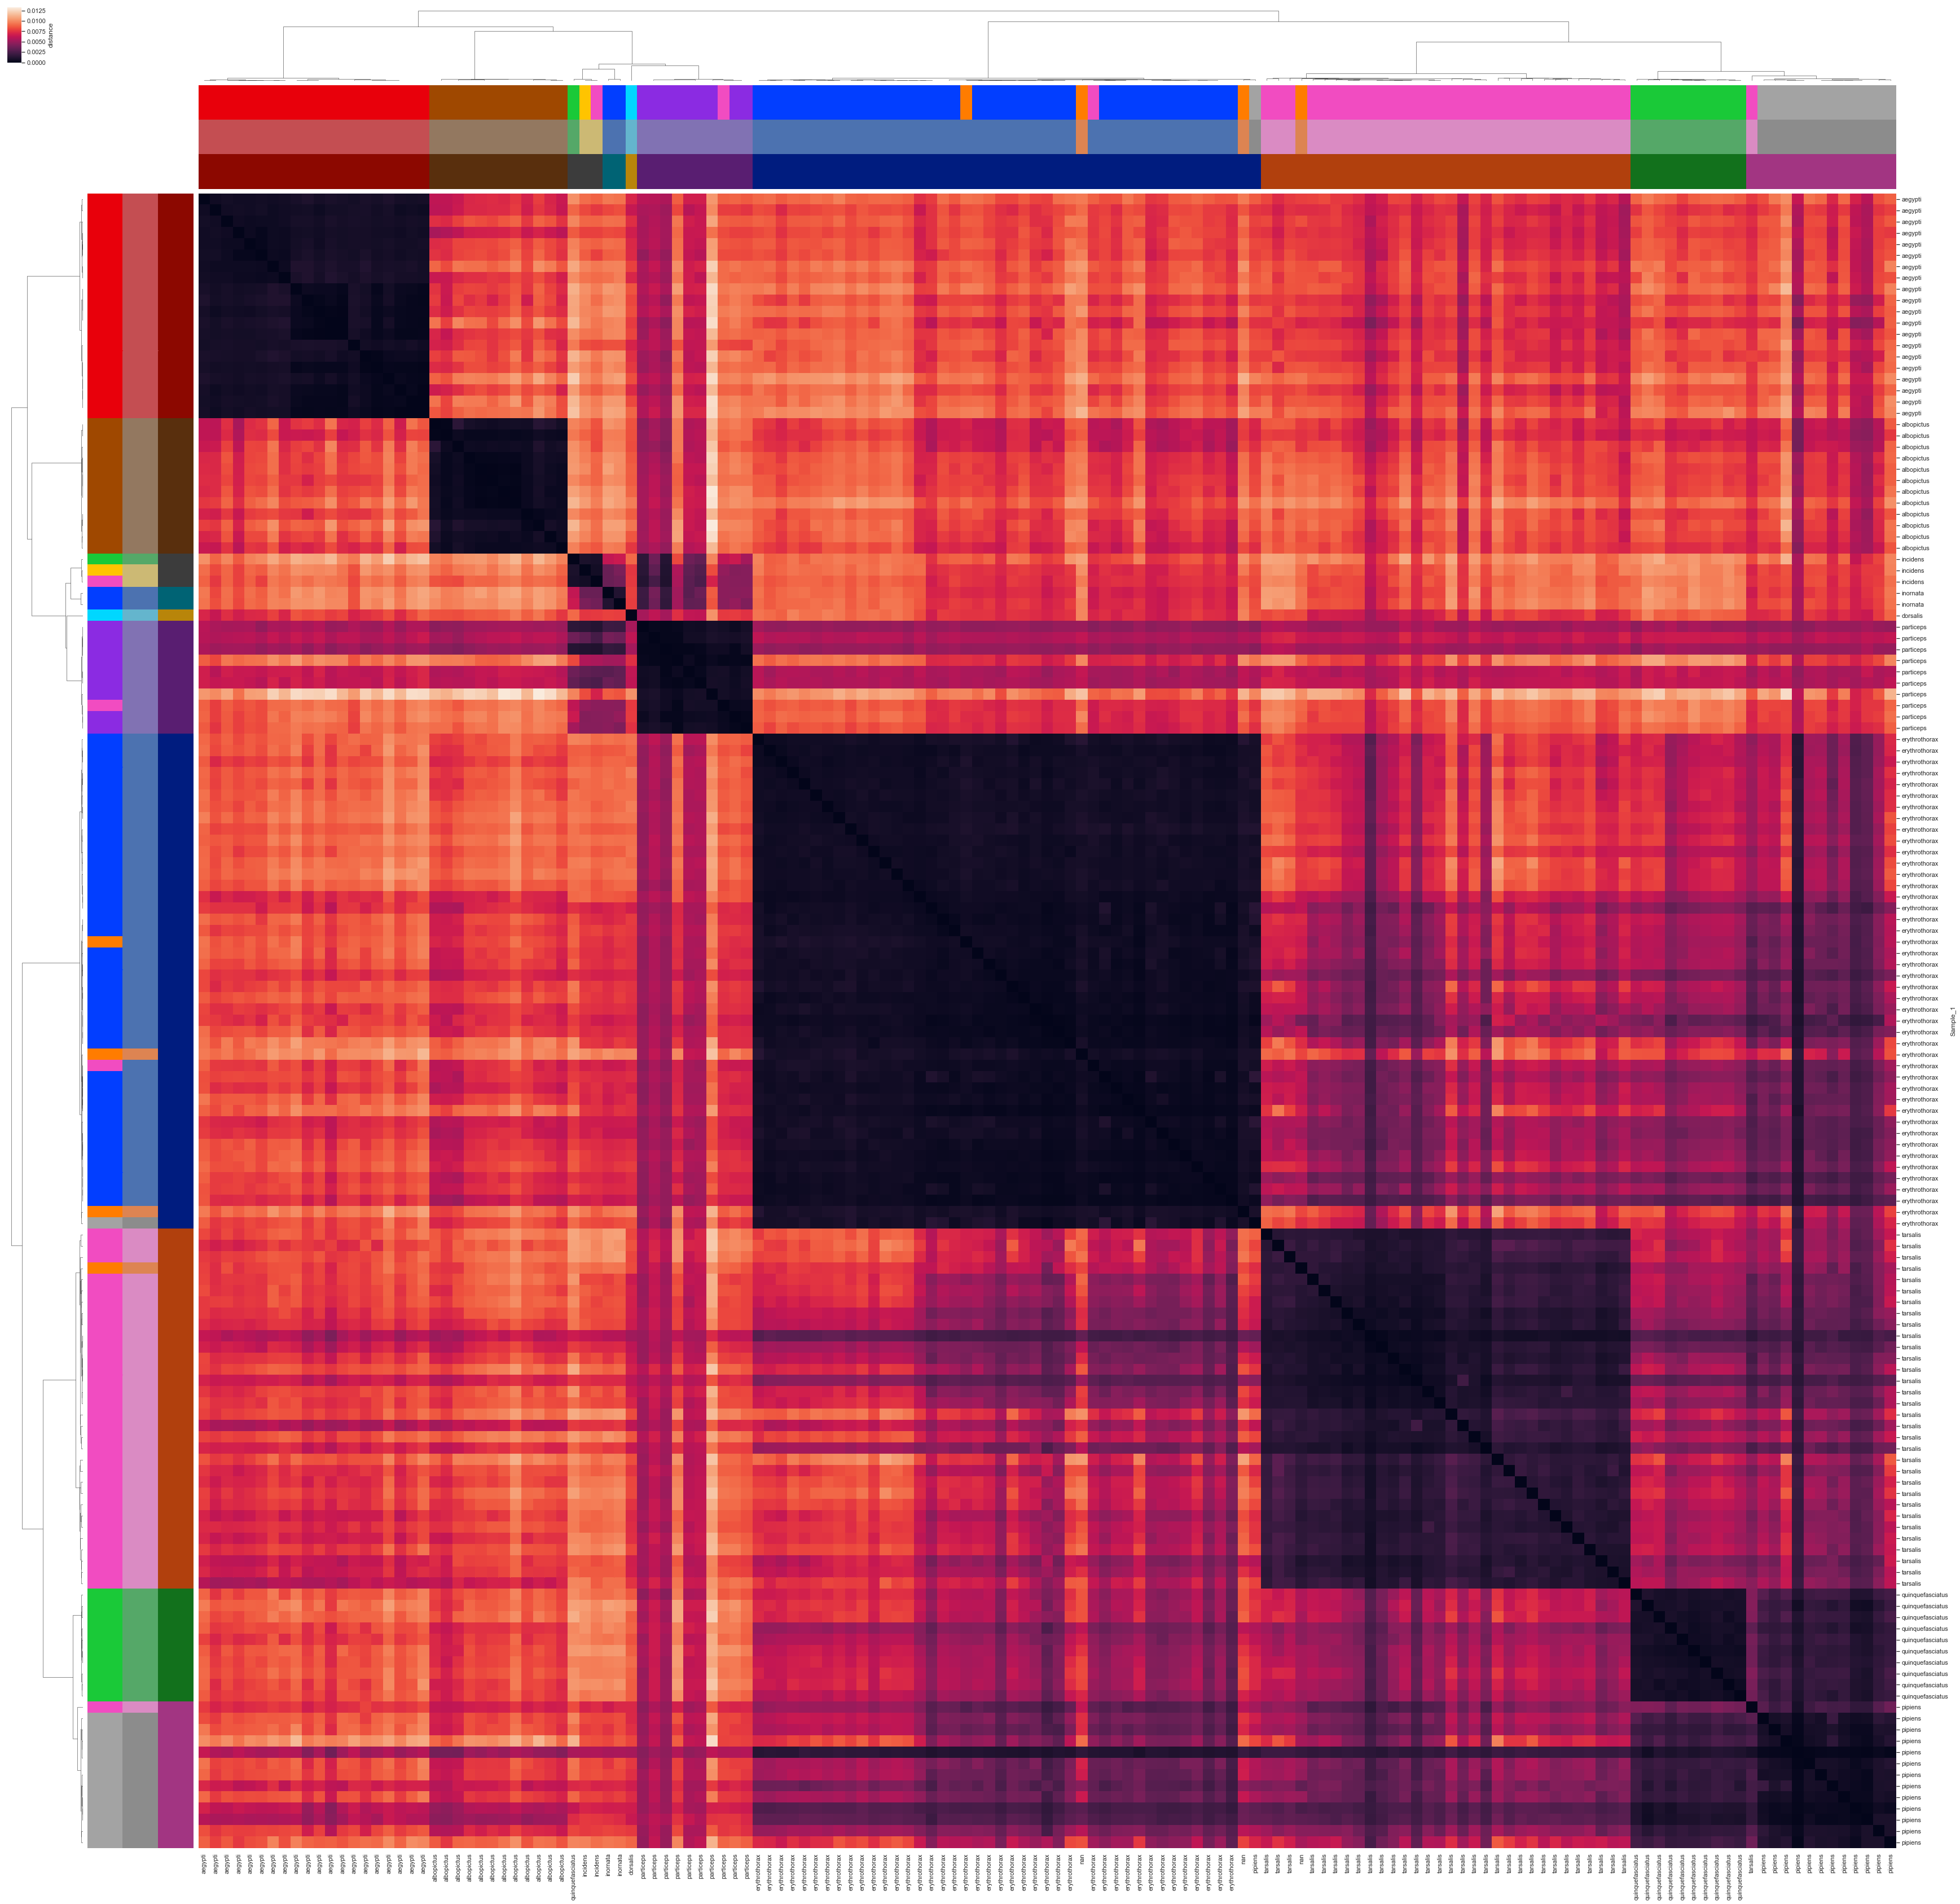

In [16]:
# this time with truncated fastqs

wrap_clustermap_and_mismatches(
    "s3://phoenixlogan-sketches/k15_10000000.distances.tsv", 
    species_id_skeeters, 
    tailing="_001_10000000_15",
    k=10, 
    figsize = (60,60), 
    values="SNP_distance", 
    diagonal=0
)


In [17]:
silhouette_snp = get_silhouette_score(
    "s3://phoenixlogan-sketches/k15_10000000.distances.tsv", 
    species_id_skeeters, 
    "_001_10000000_15", 
    values="SNP_distance"
)

silhouette_mash = get_silhouette_score(
    "s3://phoenixlogan-sketches/k15_10000000.distances.tsv", 
    species_id_skeeters, 
    "_001_10000000_15", 
    values="Mash-like_distance"
)

print(
    "silhouettes: ",
    f"SNP Distance {silhouette_snp}", 
    f"Mash Distance: {silhouette_mash}"
)

/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


silhouettes:  SNP Distance 0.7701101932348613 Mash Distance: 0.25051148203205276


/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

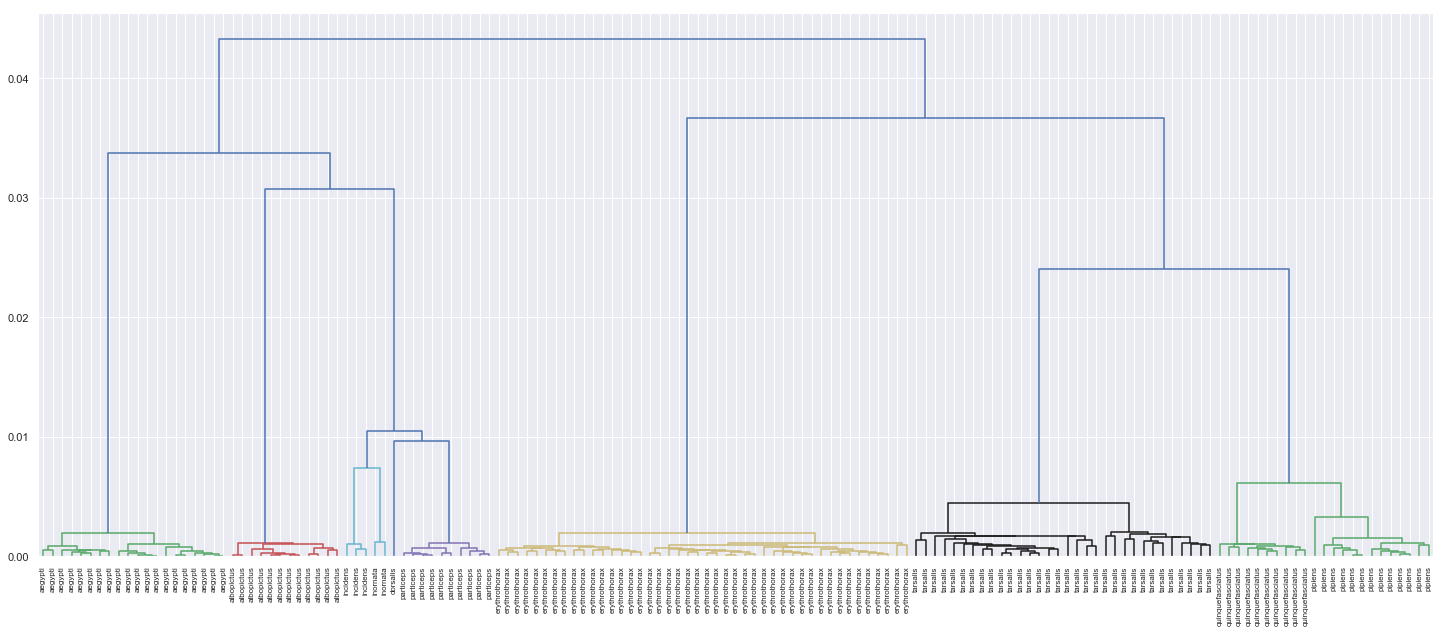

In [18]:
dn = hierarchical_clustering(
    "s3://phoenixlogan-sketches/k15_10000000.distances.tsv",
    species_id_skeeters, 
    "_001_10000000_15", 
    10,
    values="SNP_distance"
)

In [19]:
# similarity between mismatches old and new metadata

mismatches_joined = pd.merge(
    mismatches_w_new.reset_index()[[
        "Sample_1",
        "genus",
        "species",
        "sourmash_genus",
        "sourmash_species",
        "ska_genus",
        "ska_species"
    ]],
    mismatches_w_skeeters.reset_index()[[
        "Sample_1",
        "ska_genus",
        "ska_species"
    ]],
    on="Sample_1",
    suffixes = (
        "_new",
        "_old"
    )
    
)
mismatches_w_skeeters.query(
        'species != sourmash_species | ' + 
        'species != ska_species | ' + 
        'sourmash_species != ska_species'
    )

NameError: name 'mismatches_w_new' is not defined

In [21]:
from collections import namedtuple
from numpy import nan

import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import pdist, squareform
import plotly.graph_objects as go
import plotly.figure_factory as ff
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="mosquito_locator")

final_pivot_w_labels, cluster_map, linkage = join_on_ska_labels(
    "s3://phoenixlogan-sketches/k15_10000000.distances.tsv",
    species_id_skeeters,
    "_001_10000000_15",
    10
)

new_metadata = pd.read_csv(
    "/Users/phoenix.logan/code/skeeters/data/CMS001_CMS002_MergedAnnotations.csv", 
    header = 0, 
    index_col = "czbiohub-mosquito_sequences_id",
)

counties = [
    'Alameda County',
    'San Diego County',
    'San Bernardino County',
    'Riverside County',
    'Placer County',
    'Sacramento County',
] 

all_metadata = pd.merge(
    final_pivot_w_labels.reset_index()[[
        "Sample_1", 
        "genus", 
        "species", 
        "sourmash_genus",
        "sourmash_species",
        "ska_genus",
        "ska_species"
    ]],
    new_metadata.drop([
        'NewIDseqName', 
        'OldIDseqName',
        'raw_sequence_run_directory',
        'visual_genus',
        'visual_species',
        'compute_genus',
        'compute_species'
    ], axis=1),
    how='left',
    left_on="Sample_1", 
    right_index=True
).set_index("Sample_1")


def get_location(row):
    lat = row['collection_lat']
    long = row['collection_long']
    if np.isnan(lat) or np.isnan(long):
        return np.nan
    else:
        print(f"finding location for {lat}, {long}")
        loc = geolocator.reverse(f"{lat}, {long}")
        return loc.address
    
    
def get_county(row):
    address = row['location_address']
    
    if type(address) != str:
        return np.nan
    
    else:
        if 'Alameda' in address:
            return 'Alameda'

        elif 'San Diego' in address:
            return 'San Diego'

        elif 'San Bernardino' in address:
            return 'San Bernardino'

        elif 'Riverside' in address:
            return 'Riverside'

        elif 'Placer' in address:
            return 'Placer'

        elif 'Sacramento' in address:
            return 'Sacramento'

        else:
            return 'Other'

        
def get_region(row):
    
    county = row['county']
    northern_counties = [
        'Alameda',
        'Placer',
        'Sacramento'
    ]
    southern_counties = [
        'San Bernardino',
        'Riverside', 
        'San Diego'
    ]
    
    if type(county) != str:
        return np.nan
    
    else:
        if county in northern_counties:
            return 'Northern California'
        
        elif county in southern_counties:
            return 'Southern California'
        
        else:
            return 'Other'
        
        
all_metadata['location_address'] = all_metadata.apply(get_location, axis=1)
all_metadata['county'] = all_metadata.apply(get_county, axis=1)
all_metadata['region'] = all_metadata.apply(get_region, axis=1)

label_dicts = [
    all_metadata[i]
    for i in all_metadata.keys()
]

# label_dicts

all_metadata_pivot = pd.merge(
    final_pivot_w_labels.reset_index(),
    all_metadata.reset_index()[[
        "Sample_1",
        "sex",
        "county",
        "region",
        "life_stage"
    ]],
    how='left',
    left_on="Sample_1", 
    right_on="Sample_1",
).set_index([
    "Sample_1", 
    "genus", 
    "species",
    "sourmash_genus",
    "sourmash_species",
    "ska_genus",
    "ska_species",
    "sex",
    "county",
    "region",
    "life_stage"
])
all_metadata_pivot.head()

/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



KeyError: "['raw_sequence_run_directory'] not found in axis"

In [ ]:
def create_colorbars(pivot_w_labels, fig, orientation, field, index, color_palette, xaxis_label, yaxis_label):
    species_lookup = pivot_w_labels.reset_index()[[
            "Sample_1",
            "species",
            "sourmash_species",
            "ska_species"
        ]].set_index("Sample_1").to_dict('index')
    
    if index:
        label_vals = pivot_w_labels.reset_index()[field].unique()
    else:
        label_vals = pivot_w_labels[field].unique()
    
    species_coloring = dict(
            zip(
                label_vals, 
                sns.color_palette(color_palette, len(label_vals))
            )
        )
    # incase nan value color grey
    species_coloring[nan] = (220, 220, 220)

    species_labels = [
        all_meta_lookup[i][field] 
        for i in list(fig['layout']['xaxis']['ticktext'])
    ]

    species_marker_colors = [
        "rgb"+ str(species_coloring[all_meta_lookup[i][field]])
        for i in list(fig['layout']['xaxis']['ticktext'])   
    ]

    x_vals = list(pivot_w_labels.index.get_level_values(0))
    y_vals = [10 for i in pivot_w_labels.index.get_level_values(0)]

    if orientation == 'h':
        x_vals = [10 for i in pivot_w_labels.index.get_level_values(0)]
        y_vals = list(pivot_w_labels.index.get_level_values(0))

    bar_color_labels = go.Bar(
        x=x_vals,
        y=y_vals,
        marker_color=species_marker_colors,
        hovertext=species_labels,
#             hovertext=label_dicts,
        xaxis=xaxis_label,
        yaxis=yaxis_label,
        orientation=orientation
    )           

    return bar_color_labels   

In [ ]:
#exploring
def create_clustermap(pivot_w_labels):

    ### Create/Add Dendograms ###
    # Initialize figure by creating upper dendrogram
    fig = ff.create_dendrogram(
        pivot_w_labels,
        orientation='bottom',
        distfun=lambda x: pdist(x, metric="correlation"),
        linkagefun=lambda x: sch.linkage(x, "ward", optimal_ordering=True),
        color_threshold=0.4,
        labels=list(pivot_w_labels.index.get_level_values(0)),
    )

    for i in range(len(fig['data'])):
        fig['data'][i]['yaxis'] = 'y2'

    # Create Side Dendrogram
    dendro_side = ff.create_dendrogram(
        pivot_w_labels,
        orientation='right',
        distfun=lambda x: pdist(x, metric="correlation"),
        color_threshold=0.4,
        linkagefun=lambda x: sch.linkage(x, "ward", optimal_ordering=True),    
    )

    for i in range(len(dendro_side['data'])):
        dendro_side['data'][i]['xaxis'] = 'x2'

    # Add Side Dendrogram Data to Figure
    for data in dendro_side['data']:
        fig.add_trace(data)

    ### Add in color bar/cluster labels ###
    color_bar_meta = namedtuple('colorbar_data', [
        'orientation',
        'labeling_type',
        'index',
        'color_palette',
        'xaxis_label',
        'yaxis_label'
        ]
    )
    
    color_bar_data = [
        color_bar_meta('v', 'species', 2, 'bright', 'x5', 'y5'),
        color_bar_meta('v','sourmash_species', 4, 'deep', 'x4', 'y4'),
        color_bar_meta('v','ska_species', 6, 'dark', 'x3', 'y3'),
        color_bar_meta('h', 'species', 2, 'bright', 'x6', 'y6'),
        color_bar_meta('h','sourmash_species', 4, 'deep', 'x7', 'y7'),
        color_bar_meta('h','ska_species', 6, 'dark', 'x8', 'y8')
    ]
    
    for species_meta in color_bar_data:
        color_bar = create_colorbars(pivot_w_labels, fig, *species_meta)
        fig.add_trace(color_bar)
        

    ### Create Heatmap ###
    dendro_leaves = dendro_side['layout']['yaxis']['ticktext']
    dendro_leaves = list(map(int, dendro_leaves))

    data_dist = pdist(pivot_w_labels, metric="correlation")
    heat_data = squareform(data_dist)
    heat_data = heat_data[dendro_leaves, :]
    heat_data = heat_data[:, dendro_leaves]

    heatmap = [
        go.Heatmap(
            x=dendro_leaves,
            y=dendro_leaves,
            z=heat_data,
            colorscale='magma',
            #reversescale = True,
        )
    ]

    heatmap[0]['x'] = fig['layout']['xaxis']['tickvals']
    heatmap[0]['y'] = dendro_side['layout']['yaxis']['tickvals']

    # Add Heatmap Data to Figure
    for data in heatmap:
        fig.add_trace(data)
        
    ### Edit Layout ###
    fig.update_layout({
        'width': 1200, 
        'height': 1200,
        'showlegend': False, 
        'hovermode': 'closest',
        'font': dict(size=8),
    })

    # Edit xaxis
    fig.update_layout(
        xaxis={
            'domain': [.2, 1],
            'mirror': False,
            'showgrid': False,
            'showline': False,
            'zeroline': False,
            'showticklabels': False,                     
            #'tickangle': 45,
            'ticks': ""
        }
    )
    # Edit xaxis2
    fig.update_layout(
        xaxis2={
            'domain': [0, .15],
            'mirror': False,
            'showgrid': False,
            'showline': False,
            'zeroline': False,
            'showticklabels': False,
            #'tickangle': 45,
            'ticks': ""
        }
    )

    # Edit xaxis3
    fig.update_layout(
        xaxis3={
            'domain': [0.2, 1],
            'mirror': False,
            'showgrid': False,
            'showline': False,
            'zeroline': False,
            'showticklabels': False,
            'tickangle': 45,
            'ticks': ""
        }
    )

    # Edit xaxis4
    fig.update_layout(
        xaxis4={
            'domain': [0.2, 1],
            'mirror': False,
            'showgrid': False,
            'showline': False,
            'zeroline': False,
            'showticklabels': False,
            'tickangle': 45,
            'ticks': ""
        }
    )
    # Edit xaxis5
    fig.update_layout(
        xaxis5={
            'domain': [0.2, 1],
            'mirror': False,
            'showgrid': False,
            'showline': False,
            'zeroline': False,
            'showticklabels': False,
            'tickangle': 45,
            'ticks': ""
        }
    )
    # Edit xaxis6
    fig.update_layout(
        xaxis6={
            'domain': [.15, .16],
            'mirror': False,
            'showgrid': False,
            'showline': False,
            'zeroline': False,
            'showticklabels': False,
            'tickangle': 45,
            'ticks': ""
        }
    )

    # Edit xaxis7
    fig.update_layout(
        xaxis7={
            'domain': [.16, .17],
            'mirror': False,
            'showgrid': False,
            'showline': False,
            'zeroline': False,
            'showticklabels': False,
            'tickangle': 45,
            'ticks': ""
        }
    )
    # Edit xaxis8
    fig.update_layout(
        xaxis8={
            'domain': [.17, .18],
            'mirror': False,
            'showgrid': False,
            'showline': False,
            'zeroline': False,
            'showticklabels': False,
            'tickangle': 45,
            'ticks': ""
        }
    )

    # Edit yaxis
    fig.update_layout(
        yaxis={
            'domain': [0, .85],
            'mirror': False,
            'showgrid': False,
            'showline': False,
            'zeroline': False,
            'showticklabels': False,
            'ticks': ""
        }
    )
    # Edit yaxis2
    fig.update_layout(
        yaxis2={
            'domain': [.87, .975],
            'mirror': False,
            'showgrid': False,
            'showline': False,
            'zeroline': False,
            'showticklabels': False,
            'ticks': ""
        }
    )

    # Edit yaxis3
    fig.update_layout(
        yaxis3={
            'domain': [0.83, 0.84],
            'mirror': False,
            'showgrid': False,
            'showline': False,
            'zeroline': False,
            'showticklabels': False,
            'ticks': ""
        }
    )
    
    # Edit yaxis4
    fig.update_layout(
        yaxis4={
            'domain': [0.84, 0.85],
            'mirror': False,
            'showgrid': False,
            'showline': False,
            'zeroline': False,
            'showticklabels': False,
            'ticks': ""
        }
    )
    
    # Edit yaxis5
    fig.update_layout(
        yaxis5={
            'domain': [0.85, 0.86],
            'mirror': False,
            'showgrid': False,
            'showline': False,
            'zeroline': False,
            'showticklabels': False,
            'ticks': ""
        }
    )
    # Edit yaxis6
    fig.update_layout(
        yaxis6={
            'domain': [0, .81],
            'mirror': False,
            'showgrid': False,
            'showline': False,
            'zeroline': False,
            'showticklabels': False,
            'ticks': ""
        }
    )
    
    # Edit yaxis7
    fig.update_layout(
        yaxis7={
            'domain': [0, .81],
            'mirror': False,
            'showgrid': False,
            'showline': False,
            'zeroline': False,
            'showticklabels': False,
            'ticks': ""
        }
    )
    
    # Edit yaxis8
    fig.update_layout(
        yaxis8={
            'domain': [0, .81],
            'mirror': False,
            'showgrid': False,
            'showline': False,
            'zeroline': False,
            'showticklabels': False,
            'ticks': ""
        }
    )

    return fig

create_clustermap(all_metadata_pivot)

In [ ]:
species_lookup

In [ ]:
# p_dist = pdist(pivot_w_labels, metric="correlation")
# p_dist_squareform = scipy.spatial.distance.squareform(p_dist)

# cdist = scipy.spatial.distance.squareform(pivot_w_labels)
# Z = shc.linkage(cdist, method="ward")
    ### Add in color bar/cluster labels ###
color_bar_meta = namedtuple('colorbar_data', [
    'orientation',
    'field',
    'index',
    'color_palette',
    'xaxis_label',
    'yaxis_label'
    ]
)

# color_bar_data = [
#     color_bar_meta('v', 'region', 2, 'bright', 'x4', 'y4'),
#     color_bar_meta('v','species', 2, 'deep', 'x3', 'y3'),
#     color_bar_meta('v','ska_species', 6, 'dark', 'x2', 'y2'),
# ]

all_meta_lookup = all_metadata.set_index("Sample_1").to_dict('index')

def create_dendogram(pivot_w_labels):
    fig = ff.create_dendrogram(
            pivot_w_labels,
            orientation='bottom', 
            distfun=lambda x: pdist(x, metric="correlation"),
            linkagefun=lambda x: sch.linkage(x, "ward"),
            color_threshold=0.5,
            labels=list(pivot_w_labels.index.get_level_values(0)),
        )
    
    color_bar_data = [
        color_bar_meta('v', 'species', 2, 'bright', 'x4', 'y4'),
        color_bar_meta('v','sourmash_species', 4, 'deep', 'x3', 'y3'),
        color_bar_meta('v','ska_species', 6, 'dark', 'x2', 'y2'),
#         color_bar_meta('h', 'species', 2, 'bright', 'x6', 'y6'),
#         color_bar_meta('h','sourmash_species', 4, 'deep', 'x7', 'y7'),
#         color_bar_meta('h','ska_species', 6, 'dark', 'x8', 'y8')
    ]
    
    for species_meta in color_bar_data:
        color_bar = create_colorbars(pivot_w_labels, fig, *species_meta)
        fig.add_trace(color_bar)
        
#     fig = ff.create_dendrogram(
#         pivot_w_labels,
#         orientation='bottom',
#         distfun=lambda x: pdist(x, metric="correlation"),
#         linkagefun=lambda x: sch.linkage(x, "ward", optimal_ordering=True),
#         color_threshold=0.4,
#         labels=list(pivot_w_labels.index.get_level_values(0)),
#     )

#     for i in range(len(fig['data'])):
#         fig['data'][i]['yaxis'] = 'y2'

#     # Create Side Dendrogram
#     dendro_side = ff.create_dendrogram(
#         pivot_w_labels,
#         orientation='right',
#         distfun=lambda x: pdist(x, metric="correlation"),
#         color_threshold=0.4,
#         linkagefun=lambda x: sch.linkage(x, "ward", optimal_ordering=True),    
#     )

#     for i in range(len(dendro_side['data'])):
#         dendro_side['data'][i]['xaxis'] = 'x2'

#     # Add Side Dendrogram Data to Figure
#     for data in dendro_side['data']:
#         fig.add_trace(data)

#     ### Add in color bar/cluster labels ###
#     color_bar_meta = namedtuple('colorbar_data', [
#         'orientation',
#         'labeling_type',
#         'index',
#         'color_palette',
#         'xaxis_label',
#         'yaxis_label'
#         ]
#     )
    
#     color_bar_data = [
#         color_bar_meta('v', 'species', 2, 'bright', 'x5', 'y5'),
#         color_bar_meta('v','sourmash_species', 4, 'deep', 'x4', 'y4'),
#         color_bar_meta('v','ska_species', 6, 'dark', 'x3', 'y3'),
# #         color_bar_meta('h', 'species', 2, 'bright', 'x6', 'y6'),
# #         color_bar_meta('h','sourmash_species', 4, 'deep', 'x7', 'y7'),
# #         color_bar_meta('h','ska_species', 6, 'dark', 'x8', 'y8')
#     ]
    
#     for species_meta in color_bar_data:
#         color_bar = create_colorbars(pivot_w_labels, fig, *species_meta)
#         fig.add_trace(color_bar)


    fig.update_layout({
            'width':1200, 
            'height':500,
            'showlegend':False, 
            'hovermode': 'closest',
            'font':dict(size=6),
        })


    fig.update_layout(xaxis={'domain': [0, 1],
                                      'mirror': False,
                                      'showgrid': False,
                                      'showline': False,
                                      'zeroline': False,
    #                                   'tickangle': 45,
                                      'showticklabels': False,
                                      'ticks':""})
    # Edit xaxis2
    fig.update_layout(xaxis2={'domain': [0, 1],
                                       'mirror': False,
                                       'showgrid': False,
                                       'showline': False,
                                       'zeroline': False,
                                       'showticklabels': False,
    #                                    'tickangle': 45,
                                       'ticks':""})
    # Edit xaxis3
    fig.update_layout(xaxis3={'domain': [0, 1],
                                       'mirror': False,
                                       'showgrid': False,
                                       'showline': False,
                                       'zeroline': False,
                                       'showticklabels': False,
    #                                    'tickangle': 45,
                                       'ticks':""})
    # Edit xaxis4
    fig.update_layout(xaxis4={'domain': [0, 1],
                                       'mirror': False,
                                       'showgrid': False,
                                       'showline': False,
                                       'zeroline': False,
                                       'showticklabels': False,
    #                                    'tickangle': 45,
                                       'ticks':""})
    # Edit yaxis
    fig.update_layout(yaxis={'domain': [0.14, 1],
                                      'mirror': False,
                                      'showgrid': False,
                                      'showline': False,
                                      'zeroline': False,
    #                                   'showticklabels': False,
                                      'ticks': ""})
    
    # Edit yaxis2
    fig.update_layout(yaxis2={'domain':[0.06, 0.8],
                                       'mirror': False,
                                       'showgrid': False,
                                       'showline': False,
                                       'zeroline': False,
                                       'showticklabels': False,
                                       'ticks':""})
    # Edit yaxis3
    fig.update_layout(yaxis3={'domain':[0.08, 0.10],
                                   'mirror': False,
                                   'showgrid': False,
                                   'showline': False,
                                   'zeroline': False,
                                   'showticklabels': False,
                                   'ticks':""})
    
    # Edit yaxis4
    fig.update_layout(yaxis4={'domain':[0.10, 0.12],
                               'mirror': False,
                               'showgrid': False,
                               'showline': False,
                               'zeroline': False,
                               'showticklabels': False,
                               'ticks':""})

    return fig


create_dendogram(all_metadata_pivot)

In [ ]:
%debug


In [ ]:
# p_dist = pdist(pivot_w_labels, metric="correlation")
# p_dist_squareform = scipy.spatial.distance.squareform(p_dist)

# cdist = scipy.spatial.distance.squareform(pivot_w_labels)
# Z = shc.linkage(cdist, method="ward")
    ### Add in color bar/cluster labels ###
color_bar_meta = namedtuple('colorbar_data', [
    'orientation',
    'labeling_type',
    'index',
    'color_palette',
    'xaxis_label',
    'yaxis_label'
    ]
)

color_bar_data = [
#     color_bar_meta('v', 'region', 2, 'bright', 'x4', 'y4'),
    color_bar_meta('v','species', 2, 'deep', 'x3', 'y3'),
    color_bar_meta('v','ska_species', 6, 'dark', 'x2', 'y2'),
]

all_meta_lookup = all_metadata.set_index("Sample_1").to_dict('index')

def create_dendogram(pivot_w_labels):
    fig = ff.create_dendrogram(
            pivot_w_labels,
            orientation='bottom', 
            distfun=lambda x: pdist(x, metric="correlation"),
            linkagefun=lambda x: sch.linkage(x, "ward"),
            color_threshold=0.5,
            labels=list(pivot_w_labels.index.get_level_values(0)),
        )
    
    species_lookup = pivot_w_labels.reset_index()[[
            "Sample_1",
            "species",
            "sourmash_species",
            "ska_species"
        ]].set_index("Sample_1").to_dict('index')
    
    for species_meta in color_bar_data:
        species_coloring = dict(
            zip(
                pivot_w_labels.index.get_level_values(species_meta.index).unique(), 
                sns.color_palette(species_meta.color_palette, 13)
            )
        )
        # incase nan value color grey
        species_coloring[nan] = (220, 220, 220)

        species_labels = [
            species_lookup[i][species_meta.labeling_type] 
            for i in list(fig['layout']['xaxis']['ticktext'])
        ]

        species_marker_colors = [
            "rgb"+ str(species_coloring[species_lookup[i][species_meta.labeling_type]])
            for i in list(fig['layout']['xaxis']['ticktext'])   
        ]

        bar_color_labels = go.Bar(
            x=list(pivot_w_labels.index.get_level_values(0)),
            y=[2 for i in pivot_w_labels.index.get_level_values(0)],
            marker_color=species_marker_colors,
            hovertext=species_labels,
#             hovertext=label_dicts,
            xaxis=species_meta.xaxis_label,
            yaxis=species_meta.yaxis_label,
            orientation=species_meta.orientation
        )           

        fig.add_trace(bar_color_labels)

    fig.update_layout({
            'width':800, 
            'height':500,
            'showlegend':False, 
            'hovermode': 'closest',
            'font':dict(size=6),
        })


    fig.update_layout(xaxis={'domain': [0, 1],
                                      'mirror': False,
                                      'showgrid': False,
                                      'showline': False,
                                      'zeroline': False,
    #                                   'tickangle': 45,
                                      'showticklabels': False,
                                      'ticks':""})
    # Edit xaxis2
    fig.update_layout(xaxis2={'domain': [0, 1],
                                       'mirror': False,
                                       'showgrid': False,
                                       'showline': False,
                                       'zeroline': False,
                                       'showticklabels': False,
    #                                    'tickangle': 45,
                                       'ticks':""})
    # Edit xaxis3
    fig.update_layout(xaxis3={'domain': [0, 1],
                                       'mirror': False,
                                       'showgrid': False,
                                       'showline': False,
                                       'zeroline': False,
                                       'showticklabels': False,
    #                                    'tickangle': 45,
                                       'ticks':""})
    # Edit xaxis4
    fig.update_layout(xaxis4={'domain': [0, 1],
                                       'mirror': False,
                                       'showgrid': False,
                                       'showline': False,
                                       'zeroline': False,
                                       'showticklabels': False,
    #                                    'tickangle': 45,
                                       'ticks':""})
    # Edit yaxis
    fig.update_layout(yaxis={'domain': [0.14, 1],
                                      'mirror': False,
                                      'showgrid': False,
                                      'showline': False,
                                      'zeroline': False,
    #                                   'showticklabels': False,
                                      'ticks': ""})
    
    # Edit yaxis2
    fig.update_layout(yaxis2={'domain':[0.08, 0.10],
                                       'mirror': False,
                                       'showgrid': False,
                                       'showline': False,
                                       'zeroline': False,
                                       'showticklabels': False,
                                       'ticks':""})
    # Edit yaxis3
    fig.update_layout(yaxis3={'domain':[0.10, 0.12],
                                   'mirror': False,
                                   'showgrid': False,
                                   'showline': False,
                                   'zeroline': False,
                                   'showticklabels': False,
                                   'ticks':""})
    
    # Edit yaxis4
    fig.update_layout(yaxis4={'domain':[0.12, 0.14],
                               'mirror': False,
                               'showgrid': False,
                               'showline': False,
                               'zeroline': False,
                               'showticklabels': False,
                               'ticks':""})

    return fig


create_dendogram(final_pivot_w_labels)

In [ ]:
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
import plotly.graph_objects as go
import plotly.figure_factory as ff
from numpy import nan

all_meta_lookup = all_metadata.set_index("Sample_1").to_dict('index')

def create_dendogram(pivot_w_labels):
    fig = ff.create_dendrogram(
            pivot_w_labels,
            orientation='bottom',
            distfun=lambda x: pdist(x, metric="correlation"),
            linkagefun=lambda x: sch.linkage(x, "ward"),
            color_threshold=0.5,
            labels=list(pivot_w_labels.index.get_level_values(6)),
        )

    ska_species_coloring = dict(
        zip(
            pivot_w_labels.index.get_level_values(6).unique(), 
            sns.color_palette("bright", 13)
        )
    )

    ska_colors = [
        "rgb" + str(ska_species_coloring[i])
        for i in list(fig['layout']['xaxis']['ticktext'])
    ]

    color_labels_ska = go.Bar(
            x=list(pivot_w_labels.index.get_level_values(0)),
            y=[2 for i in pivot_w_labels.index.get_level_values(0)],
            marker_color=ska_colors,
            xaxis='x2',
            yaxis='y2',
    )

    fig.add_trace(color_labels_ska)

    fig.update_layout({
            'width': 788,
            'height': 500,
            # 'showlegend': True,
            'hovermode': 'closest',
            'font': dict(size=6),
        })

    fig.update_layout(
        xaxis={
            'domain': [0, 1],
            'mirror': False,
            'showgrid': False,
            'showline': False,
            'zeroline': False,
            'showticklabels': False,
            'ticks': ""
        }
    )
    
    # Edit xaxis2
    fig.update_layout(
        xaxis2={
            'domain': [0, 1],
            'mirror': False,
            'showgrid': False,
            'showline': False,
            'zeroline': False,
            'showticklabels': False,
            'ticks': ""
        }
    )
    
    # Edit yaxis
    fig.update_layout(
        yaxis={
            'domain': [0.13, 1],
            'mirror': False,
            'showgrid': False,
            'showline': False,
            'zeroline': False,
            'ticks': ""
        }
    )
    
    # Edit yaxis2
    fig.update_layout(
        yaxis2={
            'domain': [0, 0.1],
            'mirror': False,
            'showgrid': False,
            'showline': False,
            'zeroline': False,
            'showticklabels': False,
            'ticks': ""
        }
    )

    return fig

create_dendogram(final_pivot_w_labels)

In [ ]:
all_metadata.set_index("Sample_1").to_dict('index')

In [ ]:
new_metadata = pd.read_csv(
    "/Users/phoenix.logan/code/skeeters/data/CMS001_CMS002_MergedAnnotations_190325.csv", 
    header = 0, 
    index_col = "czbiohub-mosquito_sequences_id",
)

all_metadata = pd.merge(
    final_pivot_w_labels.reset_index()[[
        "Sample_1", 
        "genus", 
        "species", 
        "sourmash_genus",
        "sourmash_species",
        "ska_genus",
        "ska_species"
    ]],
    new_metadata.drop([
        'NewIDseqName', 
        'OldIDseqName',
        'raw_sequence_run_directory',
        'visual_genus',
        'visual_species',
        'compute_genus',
        'compute_species'
    ], axis=1),
    how='left',
    left_on="Sample_1", 
    right_index=True
)
all_metadata.head()
    
    


In [ ]:
all_metadata.columns